# Waveform plot 
This will download continuous seismic waveforms & plot them and requires ObsPy

## Import ObsPy module

In [1]:
from obspy import read
from obspy import UTCDateTime
from obspy.clients.fdsn import Client

import obspy as ob
print("# obspy version = ",ob.__version__)

# obspy version =  1.2.1


## Import Math and NumPy module

In [2]:
import math as M
import numpy as np
print("# numpy version = ",np.__version__)

# numpy version =  1.21.1


## Set client (Data Center)
This example uses IRIS. We can use other dataceneter (e.g., NCEDC, SCEDC)

In [3]:
#client = Client("NCEDC") # data from NCEDC 
#client = Client("SCEDC") # data from SCEDC
client = Client("IRIS") # data from IRIS

## Set SNCL
Which SNCL (Station, Network, Component, Location)? 

In [4]:
#http://ds.iris.edu/mda/NV/NSMTC/
sta = "NSMTC" # station
net = "NV" # network
com = "C?Z" # to get all SA-ULN and Geophone Z data
loc = "*" # use wildcard to get all location but later I only use CNZ.B2 for the metadata check


In [5]:
# separately added PGC data for comparison
#http://ds.iris.edu/mda/CN/PGC/--/HHZ/?starttime=2017-08-10T18:10:00&endtime=2599-12-31T23:59:59
sta2 = "PGC" # station
net2 = "CN" # network
com2 = "H?Z" # component # HHZ or HNZ. HHZ is broadband and HNZ is accelerometer
loc2 = "--" # location
client2 = Client("IRIS") # data from IRIS

## Set time window


In [6]:
#M 8.2 - 101km SSW of Tres Picos, Mexico
#2017-09-08 04:49:19 (UTC)15.022°N 93.899°W47.4 km depth
start_day = "2017-09-08T04:49:19"
end_day = "2017-09-08T05:49:19"

#M 8.0 - 78km SE of Lagunas, Peru
#2019-05-26 07:41:15 (UTC)5.812°S 75.270°W122.6 km depth
start_day = "2019-05-26T07:41:15"
end_day = "2019-05-26T08:41:15"
   
#M 8.2 - 286km NNE of Ndoi Island, Fiji
#2018-08-19 00:19:40 (UTC)18.113°S 178.153°W600.0 km depth
start_day = "2018-08-19T00:19:40"
end_day = "2018-08-19T01:19:40"
   

#M 6.3 - 71km NE of Muara Siberut, Indonesia
#2017-08-31 17:06:55 (UTC)1.159°S 99.688°E43.1 km depth
#start_day = "2017-08-31T17:06:55"
#end_day = "2017-08-31T18:06:55"
   
starttime = UTCDateTime(start_day)
endtime = UTCDateTime(end_day)

## Water Level!!!

obspy default is water_level = 60 to supress signals with low signal-to-noise ratio (SNR). As we are looking at lone-period signals where SNR is not great, if we use water_level = 60, this removes all long-period signals. For our exmaple, this level seeems to be a bit low. If we use water_level = 80 or None, the fc=8.0 & h=0.7 response matches the reference CN.PGC data

https://docs.obspy.org/packages/autogen/obspy.core.trace.Trace.remove_response.html


In [7]:
water_level = 80 # or we can use None so that there is no water level used
#water_level = None

water_level_mod2 = 60 # obspy default to see how this level supress the long-period signals


## Download seismic data collected at Cascadia experiment
use get_waveforms to download data and do st.plot() for plotting 

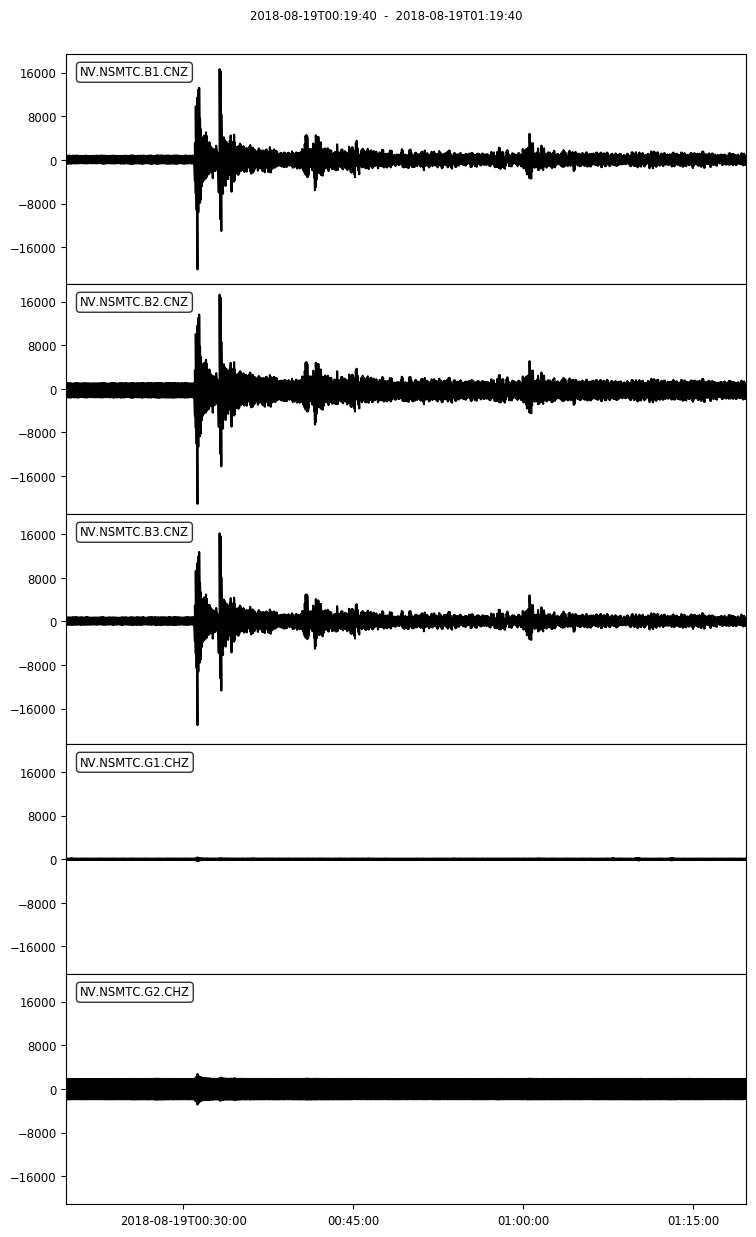

In [8]:
# st is Cascadia data
st = client.get_waveforms(network=net, station=sta, location=loc, channel=com,
                     starttime=starttime, endtime=endtime, 
                     attach_response=True)
_plot = st.plot()

# Copy original data


In [9]:
# st_mod is for an update metadata. we will use st_mod below
st_mod = st.copy()
st_mod2 = st.copy() # for geophone  water_level 60 # obspy default
st_mod3 = st.copy() # for geophone  water_level 80 # 

## Download seismic data collected at CN.PGC data
 

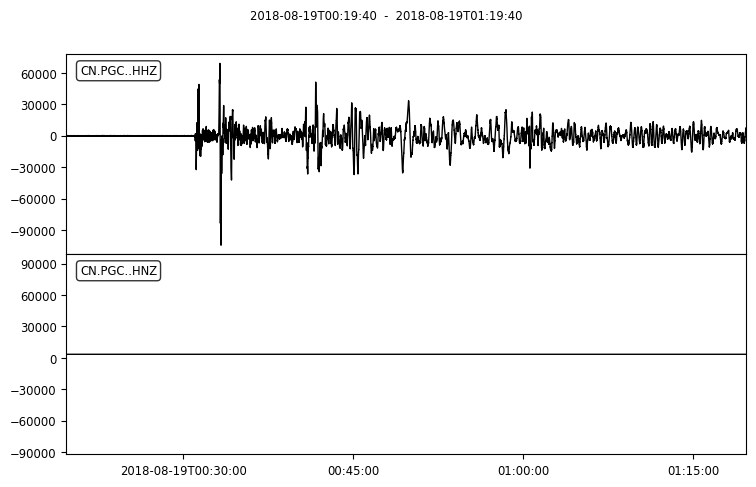

In [10]:
# st2 is referect PGC data
st2 = client2.get_waveforms(network=net2, station=sta2, location=loc2, channel=com2,
                     starttime=starttime, endtime=endtime, 
                     attach_response=True)
_plot = st2.plot()

## Correct instrument response for NV.NSMTC
use remove_response to correct the instrument response. We can select output unit (displacement, velocity or accerelation)

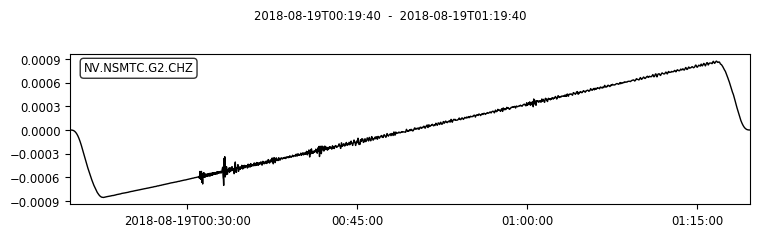

In [11]:
# select B2.CNZ data here to compere the metadata
#st = st.select(id="NV.NSMTC.B2.CNZ")
st = st.select(id="NV.NSMTC.G2.CHZ")

st.detrend() # remove liner trend
st.detrend("demean") # demean
st.taper(0.05) # cosin taper
# decimate to 100Hz
st.decimate(factor=5, strict_length=False)

#st = st.remove_response( output="VEL" ) # get velocity data (m/s)
st = st.remove_response( output="VEL", water_level=water_level ) # get velocity data (m/s)

#st = st.remove_response( output="DISP" ) # get displacement data (m)
#st = st.remove_response( output="ACC" ) # get acceleration data (m/s^2)
_plot = st.plot()


## Update channel name

In [12]:
print(st)

1 Trace(s) in Stream:
NV.NSMTC.G2.CHZ | 2018-08-19T00:19:40.000000Z - 2018-08-19T01:19:40.000000Z | 100.0 Hz, 360001 samples


In [13]:
# updated channel name so that when we plot data we can see the sensor gain value info.
#st[0].stats.channel = "CNZ-60V/g"
st[0].stats.channel = "CHZ-81.82V/m/s fc=8.0 h=0.7"


## Correct instrument response for CN.PGC

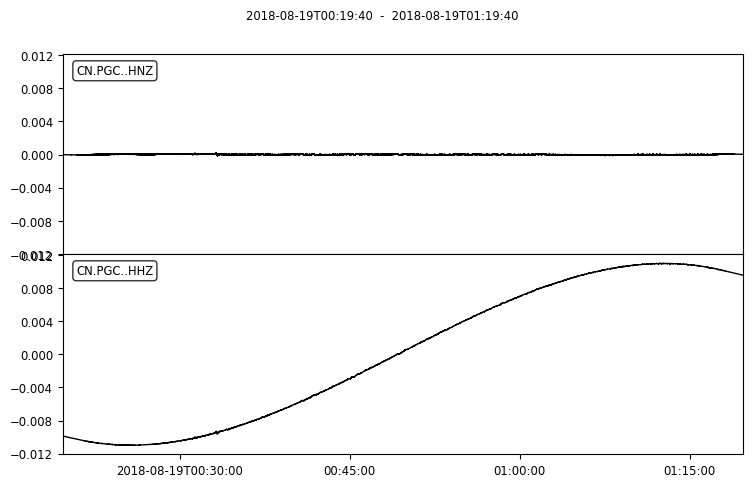

In [14]:
st2.detrend() # remove liner trend
st2.detrend("demean") # demean
st2.taper(0.05) # cosin taper
#st2 = st2.remove_response( output="VEL" ) # get velocity data (m/s)
st2 = st2.remove_response( output="VEL", water_level=water_level) # get velocity data (m/s)

#st = st.remove_response( output="DISP" ) # get displacement data (m)
#st = st.remove_response( output="ACC" ) # get acceleration data (m/s^2)
_plot = st2.plot()

## Select G2.CHZ data

In [15]:
# select G2.CHZ data only 
st_mod2 = st_mod2.select(id="NV.NSMTC.G2.CHZ")
print(st_mod2)
st_mod3 = st_mod3.select(id="NV.NSMTC.G2.CHZ")
print(st_mod3)

1 Trace(s) in Stream:
NV.NSMTC.G2.CHZ | 2018-08-19T00:19:40.000000Z - 2018-08-19T01:19:40.000000Z | 500.0 Hz, 1800001 samples
1 Trace(s) in Stream:
NV.NSMTC.G2.CHZ | 2018-08-19T00:19:40.000000Z - 2018-08-19T01:19:40.000000Z | 500.0 Hz, 1800001 samples


## Making new pole & zero

"mod2" uses a set of genertic parameters. 

In [16]:
# this should match -> http://ds.iris.edu/NRL/sensors/oyo_geospace/RESP.XX.NS387..SHZ.GS11D.4_5.380.NONE.32
G_mod2 = 32 # V/m/s (Open-Circuit Sensitivity)
fc_mod2 = 4.5 # corner frequency
damp_mod2 = 0.34 # damping (Open-Circuit Damping 34%)
#damp_mod2 = 0.70 # damping (Critical Damping 70%)


# to see if fc=8.0hz works with different h
G_mod2 = 81.82 # V/m/s (Open-Circuit Sensitivity)
fc_mod2 = 8.0 # corner frequency
damp_mod2 = 0.70 # damping (Open-Circuit Damping 34%)
#damp_mod2 = 0.9 # damping (Open-Circuit Damping 34%)


In [17]:
vars(st_mod2[0].stats.response.response_stages[0])

{'_pz_transfer_function_type': 'LAPLACE (RADIANS/SECOND)',
 '_normalization_frequency': 100.0,
 'normalization_factor': 1.0,
 '_zeros': [0j, 0j],
 '_poles': [(-35.1858+35.8967j), (-35.1858-35.8967j)],
 'stage_sequence_number': 1,
 'input_units': 'M/S',
 'output_units': 'V',
 'input_units_description': 'Velocity in Meters per Second',
 'output_units_description': 'Volts',
 'resource_id': None,
 'resource_id2': None,
 'stage_gain': 81.82,
 'stage_gain_frequency': 100.0,
 'name': None,
 'description': None,
 'decimation_input_sample_rate': None,
 'decimation_factor': None,
 'decimation_offset': None,
 'decimation_delay': None,
 'decimation_correction': None}

In [18]:
# pole & zero
poles_mod2 = [-(damp_mod2 + M.sqrt(1 - damp_mod2 ** 2) * 1j) * 2 * np.pi * fc_mod2,
                -(damp_mod2 - M.sqrt(1 - damp_mod2 ** 2) * 1j) * 2 * np.pi * fc_mod2]


print("# original pole & zero = ", st_mod2[0].stats.response.response_stages[0]._poles)
# update pole & zero
st_mod2[0].stats.response.response_stages[0]._poles = poles_mod2
#type(st_mod2[0].stats.response.response_stages[0]._poles )
print("# updated pole & zero = ", st_mod2[0].stats.response.response_stages[0]._poles)


print("# original gain value = ",st_mod2[0].stats.response.response_stages[0].stage_gain)
# update sensitivity value
# also x -1 to polarity flip
st_mod2[0].stats.response.response_stages[0].stage_gain =  G_mod2 * -1
print("# updated  gain value = ",st_mod2[0].stats.response.response_stages[0].stage_gain)


# original pole & zero =  [(-35.1858+35.8967j), (-35.1858-35.8967j)]
# updated pole & zero =  [(-35.18583772020568-35.896734539596025j), (-35.18583772020568+35.896734539596025j)]
# original gain value =  81.82
# updated  gain value =  -81.82


In [19]:
vars(st_mod2[0].stats.response.response_stages[0])

{'_pz_transfer_function_type': 'LAPLACE (RADIANS/SECOND)',
 '_normalization_frequency': 100.0,
 'normalization_factor': 1.0,
 '_zeros': [0j, 0j],
 '_poles': [(-35.18583772020568-35.896734539596025j),
  (-35.18583772020568+35.896734539596025j)],
 'stage_sequence_number': 1,
 'input_units': 'M/S',
 'output_units': 'V',
 'input_units_description': 'Velocity in Meters per Second',
 'output_units_description': 'Volts',
 'resource_id': None,
 'resource_id2': None,
 'stage_gain': -81.82,
 'stage_gain_frequency': 100.0,
 'name': None,
 'description': None,
 'decimation_input_sample_rate': None,
 'decimation_factor': None,
 'decimation_offset': None,
 'decimation_delay': None,
 'decimation_correction': None}

In [20]:
paz_mod2 = {'poles': st_mod2[0].stats.response.response_stages[0]._poles, 'zeros': st_mod2[0].stats.response.response_stages[0]._zeros,'gain': 1, 'sensitivity':1 }


In [21]:
print(paz_mod2)

{'poles': [(-35.18583772020568-35.896734539596025j), (-35.18583772020568+35.896734539596025j)], 'zeros': [0j, 0j], 'gain': 1, 'sensitivity': 1}


In [22]:
from obspy.signal.invsim import paz_2_amplitude_value_of_freq_resp

In [23]:
A0_mod2 = 1/(paz_2_amplitude_value_of_freq_resp(paz_mod2, st_mod2[0].stats.response.response_stages[0]._normalization_frequency))
print(A0_mod2)

0.9998924742191032


In [24]:
print("# original normalization_factor = ",st_mod2[0].stats.response.response_stages[0].normalization_factor)
st_mod2[0].stats.response.response_stages[0].normalization_factor = A0_mod2
print("# updated  normalization_factor = ",st_mod2[0].stats.response.response_stages[0].normalization_factor)


# original normalization_factor =  1.0
# updated  normalization_factor =  0.9998924742191032


"mod3" uses a set of parameters that provide G2.CHZ waveform fitting better to CN.PGC data

In [25]:
# this set of parameters provide G2.CHZ waveform fitting better to CN.PGC data
# but more analysis required to update the metadata"mod2" uses a set of parameters from the spechseet
G_mod3 = 1.5 # V/m/s
fc_mod3 = 1.0 # corner frequency
damp_mod3 = 0.34 # damping

G_mod3 = 81.82 # V/m/s
fc_mod3 = 8.0 # corner frequency
damp_mod3 = 0.70 # damping

In [26]:
# pole & zero
poles_mod3 = [-(damp_mod3 + M.sqrt(1 - damp_mod3 ** 2) * 1j) * 2 * np.pi * fc_mod3,
                -(damp_mod3 - M.sqrt(1 - damp_mod3 ** 2) * 1j) * 2 * np.pi * fc_mod3]


print("# original pole & zero = ", st_mod3[0].stats.response.response_stages[0]._poles)
# update pole & zero
st_mod3[0].stats.response.response_stages[0]._poles = poles_mod3
#type(st_mod3[0].stats.response.response_stages[0]._poles )
print("# updated pole & zero = ", st_mod3[0].stats.response.response_stages[0]._poles)


print("# original gain value = ",st_mod3[0].stats.response.response_stages[0].stage_gain)
# update sensitivity value
# also x -1 to polarity flip
st_mod3[0].stats.response.response_stages[0].stage_gain =  G_mod3 * -1
print("# updated  gain value = ",st_mod3[0].stats.response.response_stages[0].stage_gain)


# original pole & zero =  [(-35.1858+35.8967j), (-35.1858-35.8967j)]
# updated pole & zero =  [(-35.18583772020568-35.896734539596025j), (-35.18583772020568+35.896734539596025j)]
# original gain value =  81.82
# updated  gain value =  -81.82


In [27]:
paz_mod3 = {'poles': st_mod3[0].stats.response.response_stages[0]._poles, 'zeros': st_mod3[0].stats.response.response_stages[0]._zeros,'gain': 1, 'sensitivity':1 }


In [28]:
print(paz_mod3)

{'poles': [(-35.18583772020568-35.896734539596025j), (-35.18583772020568+35.896734539596025j)], 'zeros': [0j, 0j], 'gain': 1, 'sensitivity': 1}


In [29]:
A0_mod3 = 1/(paz_2_amplitude_value_of_freq_resp(paz_mod3, st_mod3[0].stats.response.response_stages[0]._normalization_frequency))
print(A0_mod3)

0.9998924742191032


In [30]:
print("# original normalization_factor = ",st_mod3[0].stats.response.response_stages[0].normalization_factor)
st_mod3[0].stats.response.response_stages[0].normalization_factor = A0_mod3
print("# updated  normalization_factor = ",st_mod3[0].stats.response.response_stages[0].normalization_factor)


# original normalization_factor =  1.0
# updated  normalization_factor =  0.9998924742191032


## Correct instrument response for G2.CHZ data with  updated resp files

water_leve2 = 60 <- obspy default. "mod2" uses a set of parameters from the spechseet

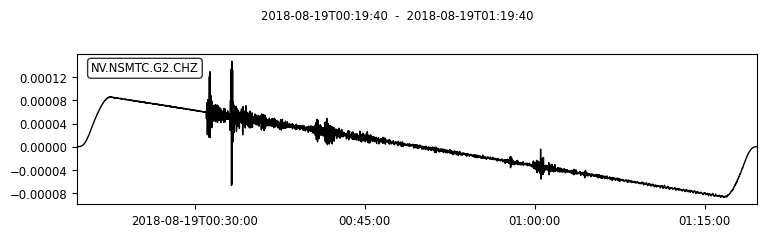

In [31]:
# remove instrument response for st_mod
st_mod2.detrend() # remove liner trend
st_mod2.detrend("demean") # demean
st_mod2.taper(0.05) # cosin taper

# decimate to 100Hz
st_mod2.decimate(factor=5, strict_length=False)
#st_mod2 = st_mod2.remove_response( output="VEL" ) # get velocity data (m/s)
st_mod2 = st_mod2.remove_response( output="VEL" , water_level=water_level_mod2) # get velocity data (m/s)

_plot = st_mod2.plot()


"mod3" uses a set of parameters that provide G2.CHZ waveform fitting better to CN.PGC data

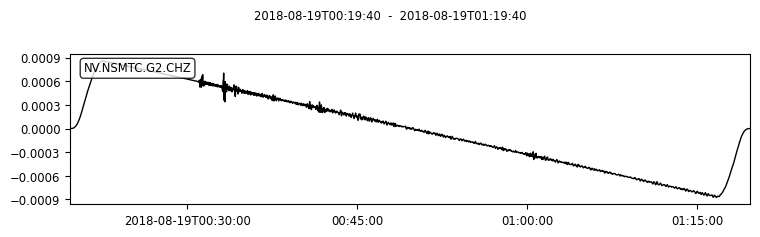

In [32]:
st_mod3.detrend() # remove liner trend
st_mod3.detrend("demean") # demean
st_mod3.taper(0.05) # cosin taper

# decimate to 100Hz
st_mod3.decimate(factor=5, strict_length=False)
#st_mod3 = st_mod3.remove_response( output="VEL" ) # get velocity data (m/s)
st_mod3 = st_mod3.remove_response( output="VEL", water_level=water_level ) # get velocity data (m/s)

_plot = st_mod3.plot()


## Update channel name and location code

In [33]:
# updated channel name so that when we plot data we can see the sensor gain value info.
# location code is B2 -> C2 so that tihs treace would be plotted before G2 data. only plotting purpose
#st_mod2[0].stats.channel = "CHZ-32V/m/s x -1 fc=4.5 h=0.34"
#st_mod2[0].stats.channel = "CHZ-"+str(G_mod2)+"V/m/s x -1 fc="+str(fc_mod2)+" h="+str(damp_mod2)
st_mod2[0].stats.channel = "CHZ-"+str(G_mod2)+"V/m/s x -1 fc="+str(fc_mod2)+" h="+str(damp_mod2)+" wt= "+str(water_level_mod2)

st_mod2[0].stats.location = "C2"

In [34]:
# updated channel name so that when we plot data we can see the sensor gain value info.
# location code is B2 -> C2 so that tihs treace would be plotted before G2 data. only plotting purpose
#st_mod3[0].stats.channel = "CHZ-1.5V/m/s x -1 fc=1.0 h=0.34"
#st_mod3[0].stats.channel = "CHZ-"+str(G_mod3)+"V/m/s x -1 fc="+str(fc_mod3)+" h="+str(damp_mod3)
st_mod3[0].stats.channel = "CHZ-"+str(G_mod3)+"V/m/s x -1 fc="+str(fc_mod3)+" h="+str(damp_mod3)+" wt= "+str(water_level)

st_mod3[0].stats.location = "C1"

## Filtering and plot

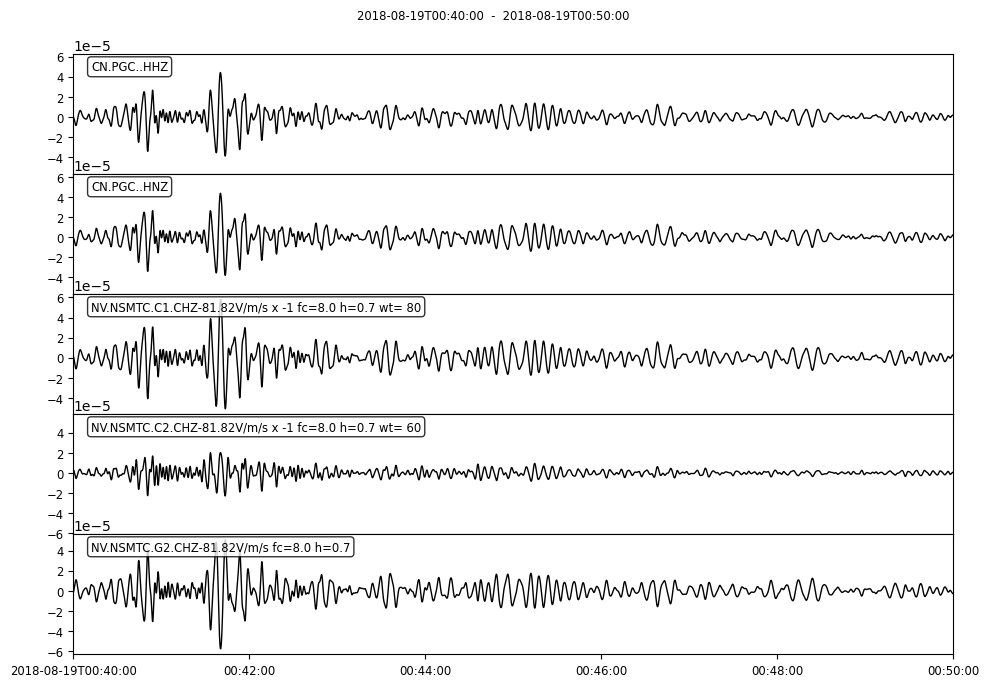

In [35]:
st_all = st2.copy() + st_mod2.copy() + st_mod3.copy ()+ st.copy()
# no need mod2
#st_all = st2.copy() + st_mod3.copy ()+ st.copy()

st_all.detrend() # remove liner trend
st_all.detrend("demean") # demean
st_all.taper(0.05) # cosin taper

fl = 0.05 # in Hz 
fh = 0.10 # in Hz

fl = 0.10 # in Hz 
fh = 0.50 # in Hz


st_all.filter(type='bandpass', freqmin=fl, freqmax=fh, corners=6, zerophase=True)


### plotting the first arrival part ###
#t1 = UTCDateTime("2017-09-08T04:56:00.00")
#t2 = UTCDateTime("2017-09-08T05:00:00.00")

# 2019 Peru
#t1 = UTCDateTime("2019-05-26T07:56:00.00")
#t2 = UTCDateTime("2019-05-26T08:00:00.00")
#t1 = UTCDateTime("2019-05-26T08:00:00.00")
#t2 = UTCDateTime("2019-05-26T08:10:00.00")

# 2018 Fiji
t1 = UTCDateTime("2018-08-19T00:40:00.00")
t2 = UTCDateTime("2018-08-19T00:50:00.00")
#_plot = st_all.plot(size=(800, 800))
_plot = st_all.plot(size=(1000, 700), starttime=t1, endtime=t2)
### plotting the first arrival part ###

### plotting surace wave(?)  part ###
#t1 = UTCDateTime("2017-09-08T05:10:00.00")
#t2 = UTCDateTime("2017-09-08T05:25:00.00")
#_plot = st_all.plot(size=(800, 800))
#_plot = st_all.plot(size=(1000, 700), starttime=t1, endtime=t2)
### plotting surace wave(?) part ###
